<a href="https://colab.research.google.com/github/Gabrikon/Solar_Energy_Production_Forecasting/blob/main/solar_TBATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TBATS MODEL

In [ ]:
#! pip install sktime

In [ ]:
import pandas as pd
import numpy as np
from tbats import TBATS
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Load and prepare data
def prepare_data(df):
    # Convert Date to datetime and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date').sort_index()

    # Use Specific Yield as it's normalized by plant capacity
    ts_data = df['Specific_Yield_kWh_kWp']

    print(f"Data range: {ts_data.index.min()} to {ts_data.index.max()}")
    print(f"Total days: {len(ts_data)}")
    print(f"Specific Yield stats - Mean: {ts_data.mean():.2f}, Std: {ts_data.std():.2f}")

    return ts_data

# Load your data
df = pd.read_csv('solar.csv')  # Load your actual data
ts = prepare_data(df)

Data range: 2022-01-01 00:00:00 to 2023-03-18 00:00:00
Total days: 442
Specific Yield stats - Mean: 18.98, Std: 20.34


In [ ]:
def tune_tbats_hyperparameters(ts, seasonal_periods=[7, 30, 365], use_box_cox=None,
                              use_trend=None, use_damped_trend=None, use_arma_errors=True):
    """
    Tune TBATS hyperparameters using time series cross-validation
    """
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    best_params = None
    best_score = float('inf')
    results = []

    # Parameter grid for tuning
    param_combinations = []

    for box_cox in [None, True, False] if use_box_cox is None else [use_box_cox]:
        for trend in [None, True, False] if use_trend is None else [use_trend]:
            for damped in [None, True, False] if use_damped_trend is None else [use_damped_trend]:
                # Skip invalid combinations
                if damped and not trend:
                    continue

                param_combinations.append({
                    'use_box_cox': box_cox,
                    'use_trend': trend,
                    'use_damped_trend': damped,
                    'use_arma_errors': use_arma_errors,
                    #'seasonal_periods': seasonal_periods
                })

    print(f"Testing {len(param_combinations)} parameter combinations...")

    for i, params in enumerate(param_combinations):
        try:
            cv_scores = []

            for train_idx, test_idx in tscv.split(ts):
                train_data = ts.iloc[train_idx]
                test_data = ts.iloc[test_idx]

                # Create and fit model
                estimator = TBATS(
                    use_box_cox=params['use_box_cox'],
                    use_trend=params['use_trend'],
                    use_damped_trend=params['use_damped_trend'],
                    use_arma_errors=params['use_arma_errors'],
                    #seasonal_periods=params['seasonal_periods']
                )

                fitted_model = estimator.fit(train_data)

                # Forecast
                forecast = fitted_model.forecast(steps=len(test_data))

                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(test_data, forecast))
                cv_scores.append(rmse)

            avg_rmse = np.mean(cv_scores)
            results.append({
                'params': params,
                'avg_rmse': avg_rmse,
                'cv_scores': cv_scores
            })

            if avg_rmse < best_score:
                best_score = avg_rmse
                best_params = params

            print(f"Combination {i+1}/{len(param_combinations)}: RMSE = {avg_rmse:.4f}")

        except Exception as e:
            print(f"Failed for params {params}: {e}")
            continue

    # Sort results by performance
    results.sort(key=lambda x: x['avg_rmse'])

    return best_params, best_score, results

In [ ]:
def comprehensive_tbats_tuning(ts):
    """
    Comprehensive tuning of core TBATS hyperparameters
    (Seasonal periods are automatically determined by sktime's TBATS wrapper)
    """
    print(f"\nTesting core hyperparameters (seasonal periods auto-detected)")

    # Only one call now, as seasonal periods are auto-detected
    best_params, best_score, results = tune_tbats_hyperparameters(ts)

    # Sort all results (which is now just the one set of results)
    all_results = results
    all_results.sort(key=lambda x: x['avg_rmse'])

    return best_params, best_score, all_results

In [ ]:
def train_final_model(ts, best_params, test_size=30):
    """
    Train final model with best parameters and evaluate
    """
    # Split data
    train_data = ts[:-test_size]
    test_data = ts[-test_size:]

    print(f"Training on {len(train_data)} days, testing on {len(test_data)} days")

    # Train final model
    final_model = TBATS(
        use_box_cox=best_params['use_box_cox'],
        use_trend=best_params['use_trend'],
        use_damped_trend=best_params['use_damped_trend'],
        use_arma_errors=best_params['use_arma_errors'],
        #seasonal_periods=best_params['seasonal_periods']
    )

    fitted_model = final_model.fit(train_data)

    # Forecast
    forecast = fitted_model.forecast(steps=len(test_data))

    # Calculate metrics
    mae = mean_absolute_error(test_data, forecast)
    rmse = np.sqrt(mean_squared_error(test_data, forecast))
    mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

    print(f"\nFinal Model Performance:")
    print(f"MAE: {mae:.4f} kWh/kWp")
    print(f"RMSE: {rmse:.4f} kWh/kWp")
    print(f"MAPE: {mape:.2f}%")

    # Convert back to Daily Yield for interpretation
    daily_yield_forecast = forecast * 234.9  # Multiply by plant capacity
    daily_yield_actual = test_data * 234.9

    print(f"\nIn Daily Yield (kWh):")
    print(f"Average Actual: {daily_yield_actual.mean():.0f} kWh")
    print(f"Average Forecast: {daily_yield_forecast.mean():.0f} kWh")

    return fitted_model, forecast, {
        'mae': mae, 'rmse': rmse, 'mape': mape,
        'daily_yield_forecast': daily_yield_forecast,
        'daily_yield_actual': daily_yield_actual
    }

In [ ]:
def plot_results(ts, train_data, test_data, forecast, model_params):
    """
    Plot training, testing and forecast results
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot full series with forecast
    ax1.plot(ts.index, ts.values, label='Actual', alpha=0.7)
    ax1.plot(test_data.index, forecast, label='Forecast', color='red', linewidth=2)
    ax1.axvline(x=train_data.index[-1], color='gray', linestyle='--', label='Train/Test Split')
    ax1.set_title('TBATS Model: Actual vs Forecast')
    ax1.set_ylabel('Specific Yield (kWh/kWp)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot test period only
    ax2.plot(test_data.index, test_data.values, label='Actual', marker='o')
    ax2.plot(test_data.index, forecast, label='Forecast', marker='s', color='red')
    ax2.set_title('Test Period: Actual vs Forecast')
    ax2.set_ylabel('Specific Yield (kWh/kWp)')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print model summary
    print("\nBest Model Parameters:")
    for key, value in model_params.items():
        print(f"  {key}: {value}")

def analyze_residuals(test_data, forecast):
    """
    Analyze forecast residuals
    """
    residuals = test_data - forecast

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Residuals plot
    ax1.plot(residuals.index, residuals.values, marker='o')
    ax1.axhline(y=0, color='red', linestyle='--')
    ax1.set_title('Forecast Residuals')
    ax1.set_ylabel('Residual (kWh/kWp)')
    ax1.grid(True, alpha=0.3)

    # Distribution of residuals
    ax2.hist(residuals, bins=15, alpha=0.7, edgecolor='black')
    ax2.axvline(x=residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.3f}')
    ax2.set_title('Residuals Distribution')
    ax2.set_xlabel('Residual (kWh/kWp)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Residuals Analysis:")
    print(f"Mean: {residuals.mean():.4f}")
    print(f"Std: {residuals.std():.4f}")
    print(f"Max: {residuals.max():.4f}")
    print(f"Min: {residuals.min():.4f}")

Data range: 2022-01-01 00:00:00 to 2023-03-18 00:00:00
Total days: 442
Specific Yield stats - Mean: 18.98, Std: 20.34
Starting comprehensive hyperparameter tuning...

Testing core hyperparameters (seasonal periods auto-detected)
Testing 21 parameter combinations...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 1/21: RMSE = 20.8387


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 2/21: RMSE = 20.8386


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 3/21: RMSE = 20.8387


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 4/21: RMSE = 20.8387


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 5/21: RMSE = 23.6334


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 6/21: RMSE = 20.8386


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 7/21: RMSE = 20.8386


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 8/21: RMSE = 20.8387


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 9/21: RMSE = 20.8386


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 10/21: RMSE = 20.8387


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 11/21: RMSE = 20.8387


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 12/21: RMSE = 23.6334


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 13/21: RMSE = 20.8386


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 14/21: RMSE = 20.8386


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Combination 15/21: RMSE = 20.0814


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Combination 16/21: RMSE = 20.4517


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Combination 17/21: RMSE = 20.2262


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Combination 18/21: RMSE = 20.2262


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Combination 19/21: RMSE = 34.8992


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Combination 20/21: RMSE = 20.4517


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Combination 21/21: RMSE = 20.4517

BEST PARAMETERS FOUND:
RMSE: 20.0814
  use_box_cox: False
  use_trend: None
  use_damped_trend: None
  use_arma_errors: True

TRAINING FINAL MODEL...
Training on 412 days, testing on 30 days


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Final Model Performance:
MAE: 17.8475 kWh/kWp
RMSE: 20.6742 kWh/kWp
MAPE: 703504.05%

In Daily Yield (kWh):
Average Actual: 3570 kWh
Average Forecast: 5613 kWh


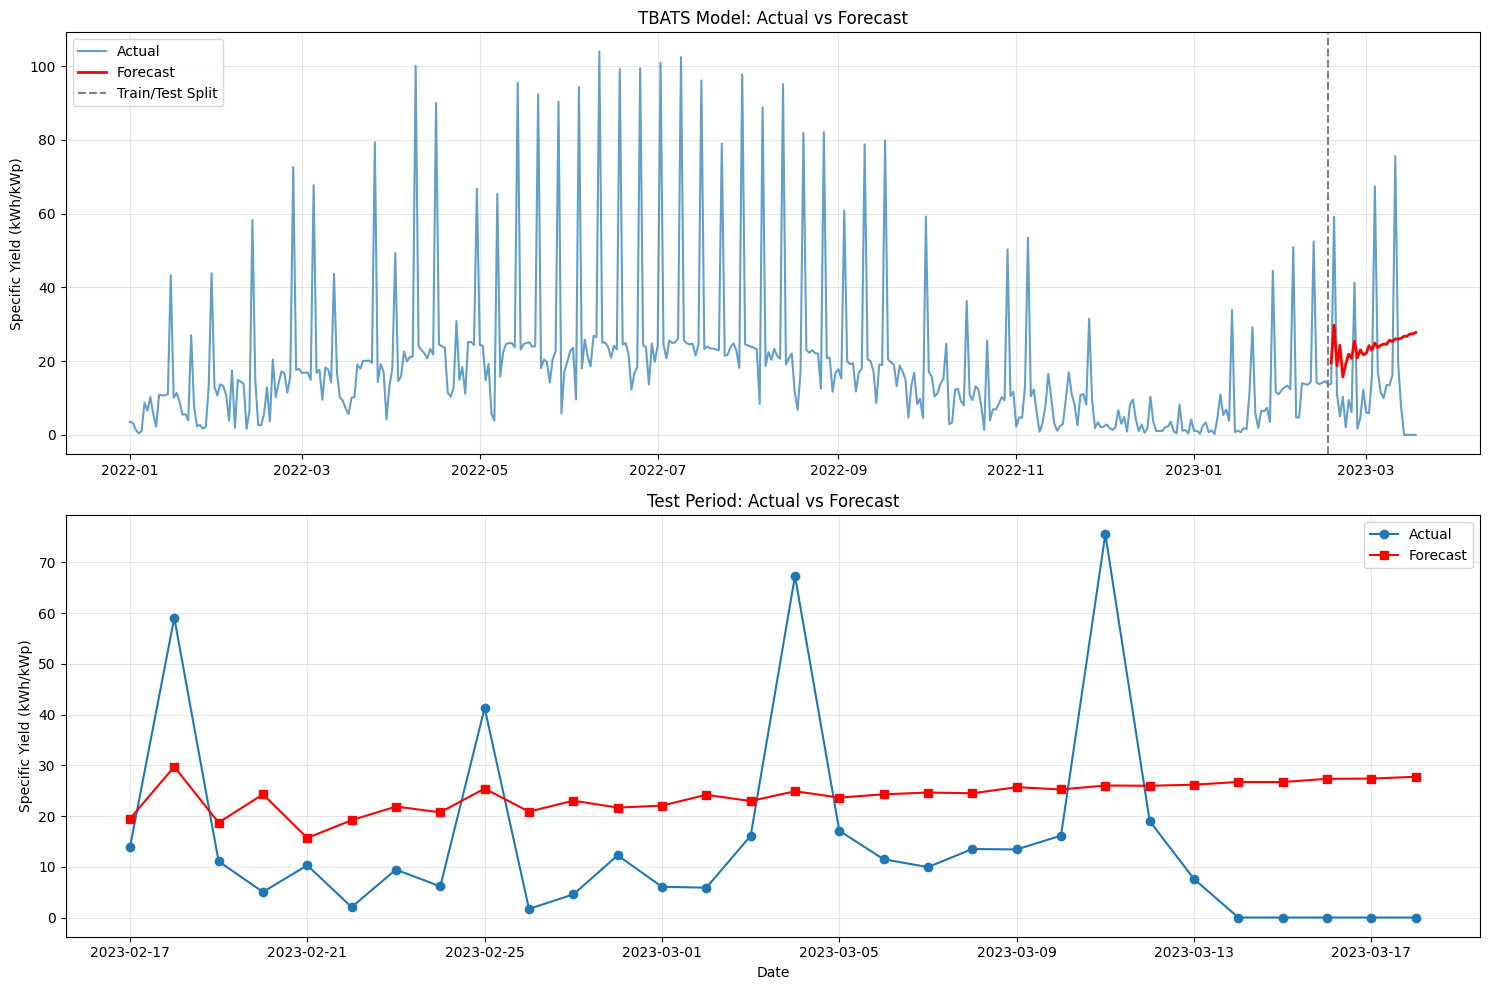


Best Model Parameters:
  use_box_cox: False
  use_trend: None
  use_damped_trend: None
  use_arma_errors: True


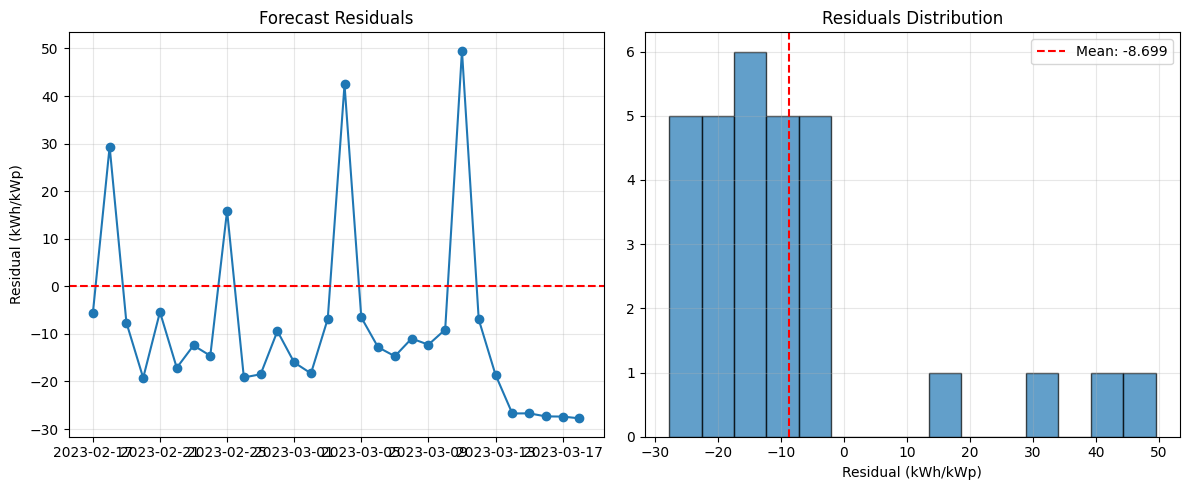

Residuals Analysis:
Mean: -8.6990
Std: 19.0756
Max: 49.5327
Min: -27.7562

TOP 5 PARAMETER COMBINATIONS:

Rank 1: RMSE = 20.0814
  use_box_cox: False
  use_trend: None
  use_damped_trend: None
  use_arma_errors: True

Rank 2: RMSE = 20.2262
  use_box_cox: False
  use_trend: True
  use_damped_trend: None
  use_arma_errors: True

Rank 3: RMSE = 20.2262
  use_box_cox: False
  use_trend: True
  use_damped_trend: True
  use_arma_errors: True

Rank 4: RMSE = 20.4517
  use_box_cox: False
  use_trend: None
  use_damped_trend: False
  use_arma_errors: True

Rank 5: RMSE = 20.4517
  use_box_cox: False
  use_trend: False
  use_damped_trend: None
  use_arma_errors: True


In [ ]:
# Main execution
if __name__ == "__main__":
    # Prepare data
    ts = prepare_data(df)

    # Perform comprehensive tuning
    print("Starting comprehensive hyperparameter tuning...")
    best_params, best_score, all_results = comprehensive_tbats_tuning(ts)

    print(f"\n{'='*50}")
    print(f"BEST PARAMETERS FOUND:")
    print(f"RMSE: {best_score:.4f}")
    for key, value in best_params.items():
        print(f"  {key}: {value}")

    # Train final model
    print(f"\n{'='*50}")
    print("TRAINING FINAL MODEL...")
    final_model, forecast, metrics = train_final_model(ts, best_params)

    # Plot results
    train_data = ts[:-30]
    test_data = ts[-30:]
    plot_results(ts, train_data, test_data, forecast, best_params)

    # Analyze residuals
    analyze_residuals(test_data, forecast)

    # Show top 5 parameter combinations
    print(f"\n{'='*50}")
    print("TOP 5 PARAMETER COMBINATIONS:")
    for i, result in enumerate(all_results[:5]):
        print(f"\nRank {i+1}: RMSE = {result['avg_rmse']:.4f}")
        for key, value in result['params'].items():
            print(f"  {key}: {value}")

In [ ]:
#! pip uninstall scipy
#! pip install scipy==1.15.0

In [ ]:
print('done')

done


In [ ]:
! pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 6.7 MB/s eta 0:00:00


## SARIMA MODEL TUNING

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
solar_df = pd.read_csv('solar.csv')

In [ ]:
def prepare_solar_data(solar_df, use_specific_yield=True):
    """
    Prepare solar data for SARIMA modeling
    """
    df = solar_df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    if use_specific_yield:
        target_series = df.set_index('Date')['Specific_Yield_kWh_kWp']
    else:
        target_series = df.set_index('Date')['Daily_Yield_kWh']

    # Ensure daily frequency and handle missing dates
    date_range = pd.date_range(start=target_series.index.min(),
                              end=target_series.index.max(), freq='D')
    target_series = target_series.reindex(date_range)

    # Fill small gaps with interpolation (common in solar data)
    if target_series.isnull().sum() > 0:
        target_series = target_series.interpolate(method='linear')

    return target_series

# Prepare your data
solar_series = prepare_solar_data(solar_df, use_specific_yield=True)
print(f"Data range: {solar_series.index.min()} to {solar_series.index.max()}")
print(f"Data points: {len(solar_series)}")
print(f"Mean specific yield: {solar_series.mean():.2f} kWh/kWp")

Data range: 2022-01-01 00:00:00 to 2023-03-18 00:00:00
Data points: 442
Mean specific yield: 18.98 kWh/kWp


ADF Statistic: -1.2753
p-value: 0.6404
Series is non-stationary


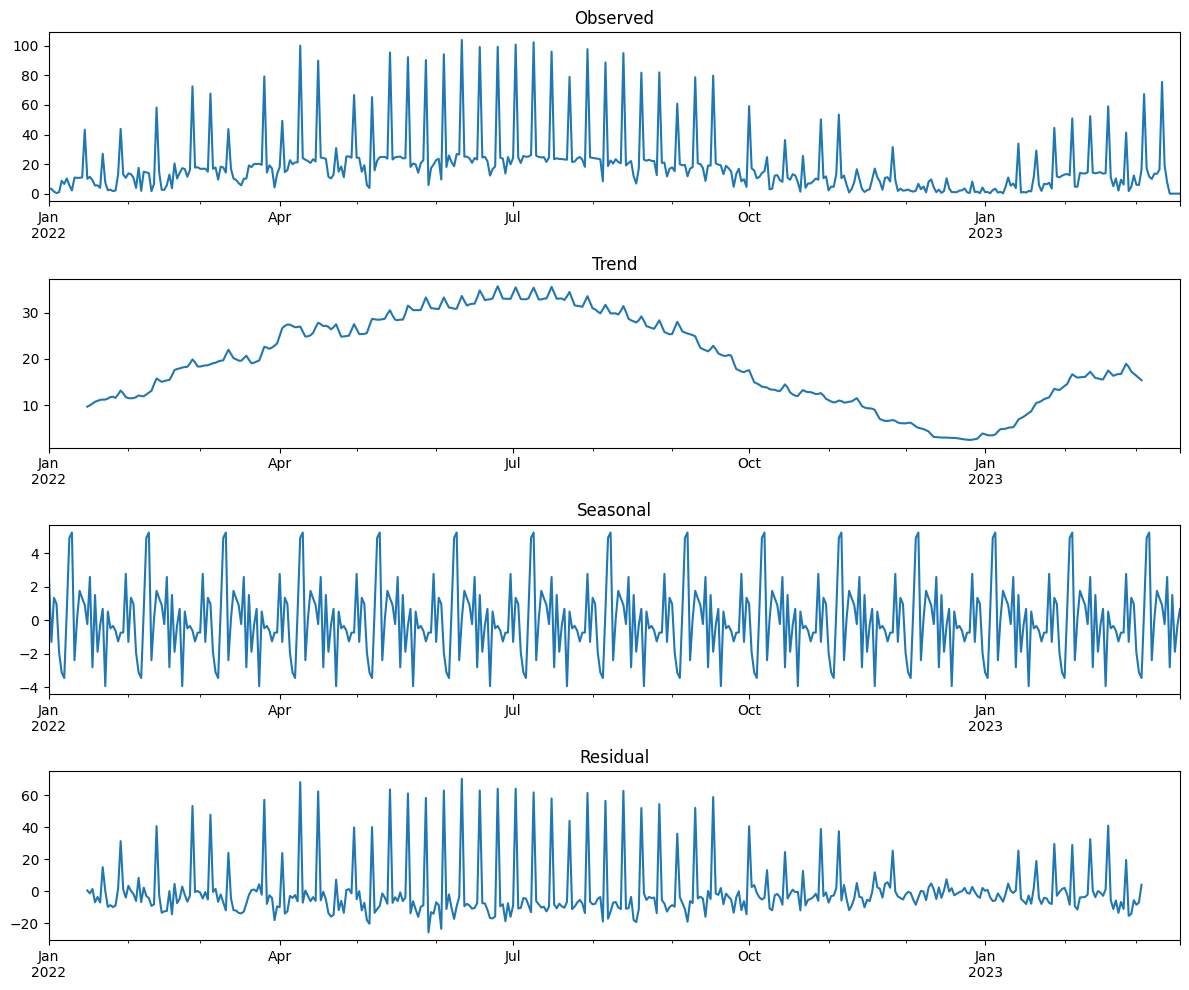

In [ ]:
def analyze_solar_seasonality(series):
    """
    Analyze seasonal patterns in solar data
    """
    # Check stationarity
    adf_result = adfuller(series.dropna())
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Series is stationary" if adf_result[1] < 0.05 else "Series is non-stationary")

    # Seasonal decomposition
    decomposition = seasonal_decompose(series, model='additive', period=30)

    # Plot decomposition
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))

    decomposition.observed.plot(ax=axes[0], title='Observed')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')

    plt.tight_layout()
    plt.show()

    return decomposition

# Analyze your data
decomposition = analyze_solar_seasonality(solar_series)

In [9]:
def sarima_grid_search(series, param_grid, seasonal_period=30):
    """
    Manual grid search for SARIMA parameters
    """
    best_score = float('inf')
    best_params = None
    best_model = None
    results = []

    for p in param_grid['p']:
        for d in param_grid['d']:
            for q in param_grid['q']:
                for P in param_grid['P']:
                    for D in param_grid['D']:
                        for Q in param_grid['Q']:
                            try:
                                model = SARIMAX(
                                    series,
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, seasonal_period),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                )
                                fitted_model = model.fit(disp=False)

                                # Calculate AIC and BIC
                                aic = fitted_model.aic
                                bic = fitted_model.bic

                                results.append({
                                    'order': (p, d, q),
                                    'seasonal_order': (P, D, Q, seasonal_period),
                                    'aic': aic,
                                    'bic': bic
                                })

                                # Use BIC for model selection (penalizes complexity)
                                if bic < best_score:
                                    best_score = bic
                                    best_params = {
                                        'order': (p, d, q),
                                        'seasonal_order': (P, D, Q, seasonal_period)
                                    }
                                    best_model = fitted_model

                                print(f"SARIMA{(p,d,q)}x{(P,D,Q,seasonal_period)} - AIC: {aic:.2f}, BIC: {bic:.2f}")

                            except Exception as e:
                                continue

    return best_params, best_model, pd.DataFrame(results)

start_time = time.time()
# Define parameter grid for solar data
solar_param_grid = {
    'p': [0, 1, 2, 3],           # AR order
    'd': [0, 1],              # Differencing
    'q': [0, 1, 2, 3],           # MA order
    'P': [0, 1, 2],              # Seasonal AR
    'D': [0, 1],              # Seasonal differencing
    'Q': [0, 1, 2]               # Seasonal MA
}

# Perform grid search
best_params, best_model, results_df = sarima_grid_search(
    solar_series, solar_param_grid, seasonal_period=30
)
end_time = time.time()
print(f"\nBest parameters: {best_params}")
print(f"Best BIC: {best_model.bic:.2f}")
print(f"Function took {end_time - start_time:.4f} seconds to run.")


SARIMA(0, 0, 0)x(0, 0, 0, 30) - AIC: 4187.31, BIC: 4191.40
SARIMA(0, 0, 0)x(0, 0, 1, 30) - AIC: 3849.38, BIC: 3857.42
SARIMA(0, 0, 0)x(0, 0, 2, 30) - AIC: 3555.40, BIC: 3567.23
SARIMA(0, 0, 0)x(0, 1, 0, 30) - AIC: 3899.49, BIC: 3903.51
SARIMA(0, 0, 0)x(0, 1, 1, 30) - AIC: 3477.69, BIC: 3485.57
SARIMA(0, 0, 0)x(0, 1, 2, 30) - AIC: 3214.52, BIC: 3226.10
SARIMA(0, 0, 0)x(1, 0, 0, 30) - AIC: 3804.49, BIC: 3812.54
SARIMA(0, 0, 0)x(1, 0, 1, 30) - AIC: 3726.13, BIC: 3738.19
SARIMA(0, 0, 0)x(1, 0, 2, 30) - AIC: 3453.45, BIC: 3469.22
SARIMA(0, 0, 0)x(1, 1, 0, 30) - AIC: 3556.34, BIC: 3564.23
SARIMA(0, 0, 0)x(1, 1, 1, 30) - AIC: 3479.42, BIC: 3491.25
SARIMA(0, 0, 0)x(1, 1, 2, 30) - AIC: 3211.96, BIC: 3227.41
SARIMA(0, 0, 0)x(2, 0, 0, 30) - AIC: 3512.14, BIC: 3523.98
SARIMA(0, 0, 0)x(2, 0, 1, 30) - AIC: 3463.56, BIC: 3479.34
SARIMA(0, 0, 0)x(2, 0, 2, 30) - AIC: 3454.21, BIC: 3473.92
SARIMA(0, 0, 0)x(2, 1, 0, 30) - AIC: 3261.35, BIC: 3272.94
SARIMA(0, 0, 0)x(2, 1, 1, 30) - AIC: 3227.12, BIC: 3242.

In [ ]:
def auto_sarima_tune(series, seasonal_period=30):
    """
    Automated SARIMA tuning using pmdarima
    """
    # For solar data with strong yearly seasonality
    model = pm.auto_arima(
        series,
        start_p=0, start_q=0,
        max_p=3, max_q=3,
        start_P=0, start_Q=0,
        max_P=2, max_Q=2,
        d=1, D=1,  # Likely need differencing for solar data
        seasonal=True,
        m=seasonal_period,
        stepwise=False,
        suppress_warnings=True,
        error_action='ignore',
        trace=True,
        information_criterion='bic',
        n_jobs=-1
    )

    return model

# Automated tuning
print("Starting automated SARIMA tuning...")
auto_model = auto_sarima_tune(solar_series, seasonal_period=30)
print(f"Best model: {auto_model}")
print(f"Best parameters: {auto_model.order} x {auto_model.seasonal_order}")

Starting automated SARIMA tuning...
